# 3. Top Tax
In this part of the project, we extend the labour supply model by introducing a non-linear tax system with a top tax. The presence of a kink in the budget constraint implies that the agent's optimization problem is no longer globally smooth, and the first-order condition may change depending on whether labour income is above or below the top-tax threshold.

We therefore analyse the household’s labour supply decision under a piecewise taxation scheme, compare numerical optimization to a structured analytical approach, and study how the kink affects the shape of the utility and FOC functions.

Building on the individual-level analysis, we then examine how labour supply reacts across the full productivity distribution, how many workers are affected by the top tax, and how this influences consumption and inequality. Finally, we evaluate the implications for social welfare, public revenues, and redistribution, and search for a welfare-maximizing combination of top-tax parameters.

In [10]:
# PREAMBLE
# Packets

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, root_scalar

# Model params
w = 1.0
L = 16.0
nu = 0.015
eps = 1.0

# Tax params (Use tau* og zeta* from part 2)
tau_star = 0.5      # <- sæt til dit tau*
zeta_star = -0.1    # <- sæt til dit zeta* (skal være <= 0 i opg. 3)

# Top tax params
kappa = 9.0
omega = 0.2

# Productivity values
p_list = [1.0, 1.175, 1.5]


### 3.1 Labor Supply
We begin by defining the piecewise tax function with a top tax rate and threshold. The tax function is defined as follows:

In [11]:
# Model Setup: Income and Utility

def income_top_tax(l, p):
    gross = w * p * l                                                   # gross income
    top_part = np.maximum(gross - kappa, 0.0)                           # income above top tax threshold
    return (1 - tau_star) * gross - omega * top_part - zeta_star


def utility(l, p):                                                      # Utility: log(c) - nu * l^(1+eps)/(1+eps). Hvis c <= 0, gives meget lav nytte så løsningen fravælges.
    c = income_top_tax(l, p)
    if c <= 0:
        return -1e10
    return np.log(c) - nu * l**(1 + eps) / (1 + eps)

# Model Setup: FOCS (before/after function kink)

def phi_before(l, p):
    c = income_top_tax(l, p)
    if c <= 0:
        return 1e10
    return (1 - tau_star) * w * p / c - nu * l**eps


def phi_after(l, p):
    c = income_top_tax(l, p)
    if c <= 0:
        return 1e10
    return (1 - tau_star - omega) * w * p / c - nu * l**eps


In [12]:
# Optimizing functions for p

def solve_by_optimizer(p):
    def obj(l):
        return -utility(l, p)   # vi minimerer -U(l)
    
    res = minimize_scalar(obj, bounds=(0.0, L), method="bounded")
    l_star = res.x
    return l_star, utility(l_star, p)


def solve_by_FOC(p):
    """
    FOC-method for p:
    1) at kink (k)
    2) before kink (b)
    3) after kink (a)
    4) Opt for the one with the highest payoff
    """
    l_k = kappa / (w * p)
    candidates = []

    # 1) before kink
    if l_k > 1e-3:
        try:
            sol_b = root_scalar(phi_before, args=(p,),
                                bracket=(1e-3, min(l_k, L) - 1e-3),
                                method="bisect")
            if sol_b.converged:
                l_b = sol_b.root
                candidates.append(("b", l_b, utility(l_b, p)))
        except ValueError:
            pass

    # 2) at kink
    if 0 < l_k < L:
        candidates.append(("k", l_k, utility(l_k, p)))

    # 3) after kink
    if l_k < L - 1e-3:
        try:
            sol_a = root_scalar(phi_after, args=(p,),
                                bracket=(max(l_k + 1e-3, 1e-3), L),
                                method="bisect")
            if sol_a.converged:
                l_a = sol_a.root
                candidates.append(("a", l_a, utility(l_a, p)))
        except ValueError:
            pass

    # (Robustness) if no solution:
    if len(candidates) == 0:
        return 0.0, utility(0.0, p), "none"

    # 4) Opt for highest payoff
    best_type, best_l, best_U = max(candidates, key=lambda x: x[2])
    return best_l, best_U, best_type


p = 1.0
  Optimizer:  l* = 8.0656, U = 0.9311
  FOC 4-trin: l* = 8.0656, U = 0.9311, type = b
p = 1.175
  Optimizer:  l* = 7.6596, U = 1.0860
  FOC 4-trin: l* = 7.6596, U = 1.0860, type = k
p = 1.5
  Optimizer:  l* = 6.3224, U = 1.2573
  FOC 4-trin: l* = 6.3224, U = 1.2573, type = a


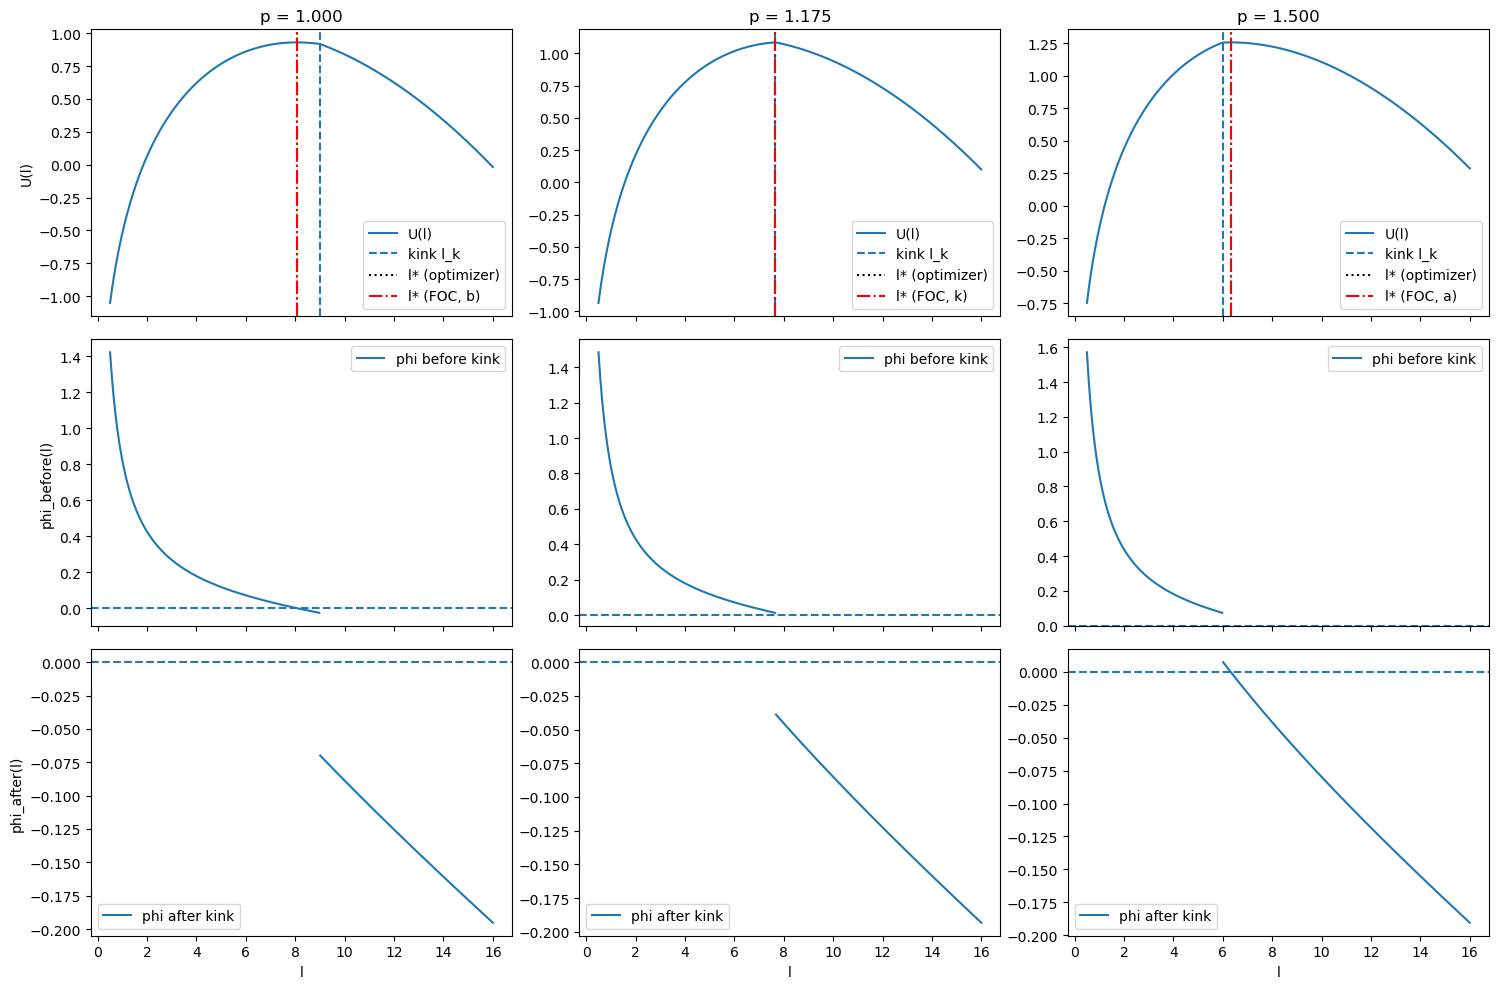

In [13]:
# Looping p and plot figure

# Figure: 3x3 subplots (3 states of p, 2 states of kink)
fig, axes = plt.subplots(3, len(p_list), figsize=(5 * len(p_list), 10), sharex=True)

# Hvis der kun var én p, ville axes være 1D, men her er der 3, så axes er 2D: [row, col]

for j, p in enumerate(p_list):
    # grid for l
    l_grid = np.linspace(0.5, L, 400)
    U_vals = np.array([utility(l, p) for l in l_grid])

    # kink-punkt
    l_k = kappa / (w * p)

    # phi før kink
    phi_before_vals = np.full_like(l_grid, np.nan, dtype=float)
    mask_before = l_grid < l_k
    phi_before_vals[mask_before] = [phi_before(l, p) for l in l_grid[mask_before]]

    # phi efter kink
    phi_after_vals = np.full_like(l_grid, np.nan, dtype=float)
    mask_after = l_grid > l_k
    phi_after_vals[mask_after] = [phi_after(l, p) for l in l_grid[mask_after]]

    # løsninger
    l_opt_num, U_opt_num = solve_by_optimizer(p)
    l_opt_foc, U_opt_foc, kind_foc = solve_by_FOC(p)

    print(f"p = {p}")
    print(f"  Optimizer:  l* = {l_opt_num:.4f}, U = {U_opt_num:.4f}")
    print(f"  FOC 4-trin: l* = {l_opt_foc:.4f}, U = {U_opt_foc:.4f}, type = {kind_foc}")

    # vælg de rette akser for denne kolonne
    ax_U   = axes[0, j]
    ax_phi_b = axes[1, j]
    ax_phi_a = axes[2, j]

    # (1) U(l)
    ax_U.plot(l_grid, U_vals, label="U(l)")
    ax_U.axvline(l_k, linestyle="--", label="kink l_k")
    ax_U.axvline(l_opt_num, color="black", linestyle=":", label="l* (optimizer)")
    ax_U.axvline(l_opt_foc, color="red", linestyle="-.", label=f"l* (FOC, {kind_foc})")
    ax_U.set_title(f"p = {p:.3f}")
    if j == 0:
        ax_U.set_ylabel("U(l)")
    ax_U.legend()

    # (2) phi før kink
    ax_phi_b.plot(l_grid, phi_before_vals, label="phi before kink")
    ax_phi_b.axhline(0, linestyle="--")
    if j == 0:
        ax_phi_b.set_ylabel("phi_before(l)")
    ax_phi_b.legend()

    # (3) phi efter kink
    ax_phi_a.plot(l_grid, phi_after_vals, label="phi after kink")
    ax_phi_a.axhline(0, linestyle="--")
    if j == 0:
        ax_phi_a.set_ylabel("phi_after(l)")
    ax_phi_a.set_xlabel("l")
    ax_phi_a.legend()

plt.tight_layout()
plt.show()



Across the three productivity levels, the optimizer and the 4-step FOC methods yield identical labour supply choices, confirming the validity of the structured approach. The optimizer and the FOC-approach yields the most different outcomes at productivity level $p=1.000$. Strictly qualitatively, the FOC-approach seems to come the closest to actual extremum. The presence of the kink introduces a discontinuity in the marginal utility of labour, due to the top tax invocation, which is captured by the two separate FOC functions before and after the kink.

### 3.2 Labour Supply Function
In task 3.2, we extend the analysis from a single representative worker to an entire distribution of productivities. The goal is to understand how the top-tax kink affects behaviour across different types of workers, not just at one parameter value. By solving the labour-supply problem for many values of productivity $p$, we obtain the full labour-supply function $\ell^*(p)$ and consumption function $c^*(p)$. This allows us to identify which workers are influenced by the top-tax threshold, how labour supply reacts around the kink, and how the tax system shapes the mapping from productivity into economic outcomes.

In [ ]:
# Computing *(p) and c(p) for multiple p-values

# P-value grid (general productivivty)
p_grid = np.linspace(0.5, 3.0, 200)   # fx 200 points between 0.5 og 3.0

l_star_list = []
c_star_list = []
type_list   = []   # 'b', 'k', 'a' osv.

for p in p_grid:
    # 4 step FOC approach
    l_star, U_star, kind = solve_by_FOC(p)
    
    # store results
    l_star_list.append(l_star)
    c_star_list.append(income_top_tax(l_star, p))  # c = y(p, l*)
    type_list.append(kind)

# convert to numpy arrays
l_star_arr = np.array(l_star_list)
c_star_arr = np.array(c_star_list)
type_arr   = np.array(type_list)


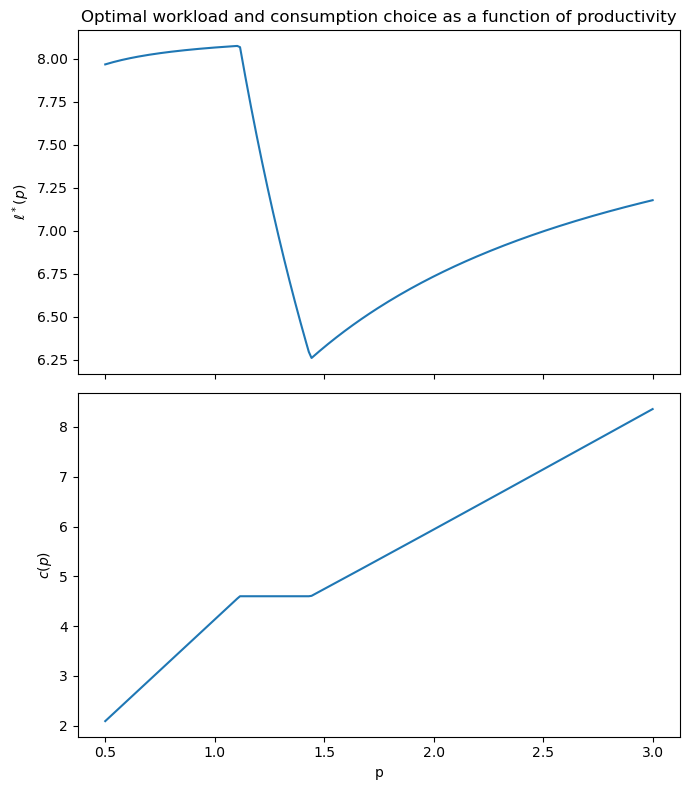

In [ ]:
# Plot l*(p) and c*(p)

fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# Labour supply
axes[0].plot(p_grid, l_star_arr)
axes[0].set_ylabel(r"$\ell^*(p)$")
axes[0].set_title("Optimal workload and consumption choice as a function of productivity")

# Consumption
axes[1].plot(p_grid, c_star_arr)
axes[1].set_ylabel(r"$c(p)$")
axes[1].set_xlabel("p")

plt.tight_layout()
plt.show()


The figure shows that optimal labour supply does not evolve smoothly with productivity. Instead, it drops sharply around the productivity level where workers reach the top-tax kink: the higher marginal tax rate reduces the return to supplying additional hours, generating a discrete downward adjustment. For both lower and higher values of $p$, labour supply behaves more smoothly.

The consumption profile similarly reflects the non-linearities induced by the tax system. Consumption generally rises with productivity but flattens around the kink region, reflecting that income gains are taxed more heavily there. Once past the kink, consumption again increases steadily. Overall, the figure illustrates how a non-linear tax schedule induces non-linear behavioural responses in both labour supply and consumption.

In [26]:
# Shares in grid before, at and after kink

N = len(type_arr)

share_b = np.mean(type_arr == "b")
share_k = np.mean(type_arr == "k")
share_a = np.mean(type_arr == "a")
share_other = 1.0 - (share_b + share_k + share_a)   # hvis der skulle være 'none' eller andet

print("Shares:")
print(f"  l* = l_b (before kink):   {share_b*100:.1f} %")
print(f"  l* = l_k (at kink):       {share_k*100:.1f} %")
print(f"  l* = l_a (after kink): {share_a*100:.1f} %")
print(f"  øvrige (fx 'none'):    {share_other*100:.1f} %")


Shares:
  l* = l_b (before kink):   24.5 %
  l* = l_k (at kink):       13.0 %
  l* = l_a (after kink): 62.5 %
  øvrige (fx 'none'):    0.0 %


The distribution of solution types shows that most individuals (about 62.5%) choose an optimal labour supply above the kink, meaning the top tax is actually binding for a majority of workers. Around 24.5% choose a point before the kink, while 13% locate their optimum exactly at the kink. This pattern reflects that higher­-productivity individuals tend to work beyond the threshold, whereas lower­-productivity individuals avoid the higher marginal tax. The absence of “none” cases confirms that the optimisation routines behave consistently across the grid.

### 3.3 Public Good
Here we move from individual labour-supply behaviour to evaluating the aggregate consequences of the tax system. The government uses tax revenue to finance a public good, and social welfare depends both on individuals’ utilities and on the level of this public good. By comparing outcomes with and without a top tax, we can assess whether the tax improves overall welfare through redistribution and higher public-good provision, or whether efficiency losses dominate. This analysis highlights the central policy trade-off between equity, efficiency, and public-good financing.

In [ ]:
# Governmental params and population
# Workers and productivity distribution
N = 100
sigma_p = 0.3

# Params for Social Welfare Function (SWF)
chi = 1/(2*N)
eta = 0.1

# Productivity to N workers - using seed 2025
rng = np.random.default_rng(seed=2025)
p_pop = rng.lognormal(mean=-0.5 * sigma_p**2, sigma=sigma_p, size=N)


In [27]:
# SWF function with top tax

def compute_swf_top_tax(tau, zeta, kappa_val, omega_val):
    """
    Should return:
      SWF  : Social Welfare Function (scalar)
      T    : Tax provenue
      U_arr: Array of individual U_i
    """
    global tau_star, zeta_star, kappa, omega

    # Store values
    old_tau   = tau_star
    old_zeta  = zeta_star
    old_kappa = kappa
    old_omega = omega

    # Temporary new tax params
    tau_star = tau
    zeta_star = zeta
    kappa = kappa_val
    omega = omega_val

    U_list = []
    tax_list = []

    for p in p_pop:
        # Optimal household choice
        l_star, U_star, kind = solve_by_FOC(p)

        # Consumption (given as post tac income)
        c_star = income_top_tax(l_star, p)

        # Gross income
        gross = w * p * l_star

        # Tax (Given as gross indome - consumption)
        tax_i = gross - c_star

        U_list.append(U_star)
        tax_list.append(tax_i)

    # Convert to arrays
    U_arr = np.array(U_list)
    tax_arr = np.array(tax_list)

    # Total provenue and SWF
    T = np.sum(tax_arr)
    G = T
    SWF = chi * (G**eta) + np.sum(U_arr)

    # Return tax values to old
    tau_star  = old_tau
    zeta_star = old_zeta
    kappa     = old_kappa
    omega     = old_omega

    return SWF, T, U_arr


In [ ]:
# 3.3.1 - SWF with/without top tax
# Tau* and Zeta* from last cell
tau_opt = tau_star
zeta_opt = zeta_star

# 1) Baeling: No top tax (Omega = 0, Kappa high)
swf_base, T_base, U_base = compute_swf_top_tax(
    tau=tau_opt,
    zeta=zeta_opt,
    kappa_val=1e6,   # Set high
    omega_val=0.0
)

# 2) With top tax: Kappa = 9, Omega = 0.2
swf_top, T_top, U_top = compute_swf_top_tax(
    tau=tau_opt,
    zeta=zeta_opt,
    kappa_val=9.0,
    omega_val=0.2
)

print("3.3.1: SWF and provenue")
print(f"SWF, no top tax: {swf_base:.4f}")
print(f"SWF, top tax : {swf_top:.4f}")
print(f"Provenue, no top tax: {T_base:.4f}")
print(f"Provenue, top tax: {T_top:.4f}")


3.3.1: SWF and provenue
SWF, no top tax: 87.8300
SWF, top tax : 86.4747
Provenue, no top tax: 393.7101
Provenue, top tax: 372.0206


Social welfare falls slightly when the top tax is introduced: SWF decreases from about 87.8 to 86.5. This reflects that the efficiency loss from reduced labour supply outweighs the modest redistribution gains in this calibration.
Similarly, total tax revenue declines from roughly 394 to 372, indicating that the higher marginal tax rate reduces overall taxable income enough to lower government revenue. Overall, the top tax is mildly welfare-reducing in this setting.

In [ ]:
# Help functions for Lorentz curve
def compute_consumption_distribution(tau, zeta, kappa_val, omega_val):
    """
    Beregner forbrug c_i for alle arbejdere under et givet skattesystem.
    Returnerer et array c_arr med længde N.
    """
    global tau_star, zeta_star, kappa, omega
    old_tau, old_zeta, old_kappa, old_omega = tau_star, zeta_star, kappa, omega

    tau_star = tau
    zeta_star = zeta
    kappa = kappa_val
    omega = omega_val

    c_list = []
    for p in p_pop:
        l_star, U_star, kind = solve_by_FOC(p)
        c_star = income_top_tax(l_star, p)
        c_list.append(c_star)

    # reset parametre
    tau_star, zeta_star, kappa, omega = old_tau, old_zeta, old_kappa, old_omega

    return np.array(c_list)


def lorenz_curve(c_arr):
    """
    Beregner Lorenz-kurvens punkter for et array af konsumtion.
    Returnerer to arrays:
      cum_pop  : kumuleret andel af befolkningen (0 til 1)
      cum_cons : kumuleret andel af konsumtion (0 til 1)
    """
    c_sorted = np.sort(c_arr)
    cum_cons = np.cumsum(c_sorted)
    total_cons = cum_cons[-1]
    cum_cons_share = cum_cons / total_cons
    cum_pop_share = np.linspace(0, 1, len(c_arr), endpoint=True)
    return cum_pop_share, cum_cons_share


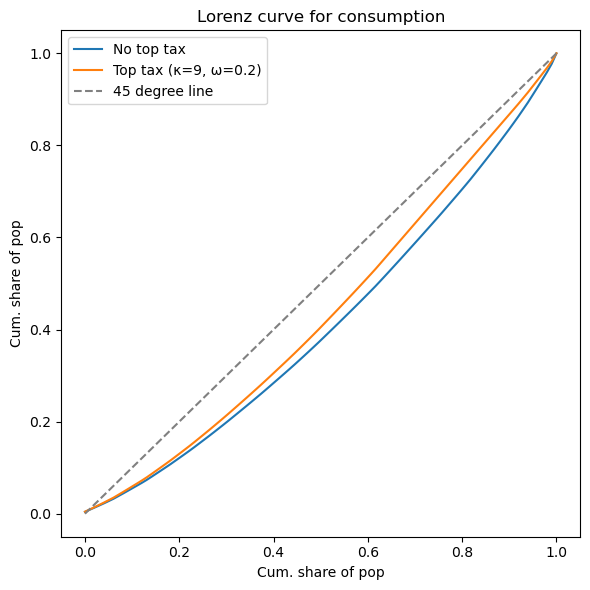

In [29]:
# 3.3.2 – Plot Lorenz curves
# Consumption, no top tax (Omega = 0, Kappa high)
c_base = compute_consumption_distribution(
    tau=tau_opt,
    zeta=zeta_opt,
    kappa_val=1e6,
    omega_val=0.0
)

# Consumption with top tax (Kappa=9, Omega=0.2)
c_top = compute_consumption_distribution(
    tau=tau_opt,
    zeta=zeta_opt,
    kappa_val=9.0,
    omega_val=0.2
)

# Compute Loretz curves
pop_base, cons_base = lorenz_curve(c_base)
pop_top, cons_top   = lorenz_curve(c_top)

# Plot setup
plt.figure(figsize=(6, 6))
plt.plot(pop_base, cons_base, label="No top tax")
plt.plot(pop_top, cons_top, label="Top tax (κ=9, ω=0.2)")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="45 degree line")
plt.xlabel("Cum. share of pop")
plt.ylabel("Cum. share of pop")
plt.title("Lorenz curve for consumption")
plt.legend()
plt.tight_layout()
plt.show()


The Lorenz curve for consumption shows that the distribution becomes slightly more equal under the top-tax system. The curve with top tax lies closer to the line of equality than the curve without top tax, indicating that high-productivity individuals contribute relatively more and low-productivity individuals receive a larger share of total consumption. The overall shift is moderate but consistent with the redistributive effect of introducing a top tax.

In [30]:
# 3.3.3 – Grid search (kappa, omega)

# Grid definition
omega_grid = np.linspace(0.0, 0.3, 7)   
kappa_grid = np.linspace(7.0, 11.0, 9)    

best_swf = -1e18
best_kappa = None
best_omega = None

for om in omega_grid:
    for kap in kappa_grid:
        swf_val, T_val, U_arr = compute_swf_top_tax(
            tau=tau_opt,
            zeta=zeta_opt,
            kappa_val=kap,
            omega_val=om
        )
        if swf_val > best_swf:
            best_swf = swf_val
            best_kappa = kap
            best_omega = om

print("3.3.3: Prefered top tax in grid")
print(f"Opt. SWF: {best_swf:.4f}")
print(f"kappa*     = {best_kappa:.3f}")
print(f"omega*     = {best_omega:.3f}")
print(f"SWF (baseline): {swf_base:.4f}")


3.3.3: Prefered top tax in grid
Opt. SWF: 87.8300
kappa*     = 7.000
omega*     = 0.000
SWF (baseline): 87.8300


The grid search shows that the welfare-maximising top tax is simply no top tax at all. The optimal parameters are kappa = 7 and omega = 0, which give exactly the same SWF as the baseline. This means that introducing a positive top tax does not improve social welfare in this calibration. The efficiency loss from higher marginal taxes outweighs the potential redistribution gains, so the government prefers a purely proportional tax system.